# Applied Stochastic Process - Group5 Project

**Author:** *Jichong Yu, Kaiwei Zhang* 

**Instructor**: *Jaehyuk Choi*

In [2]:
%load_ext autoreload
%autoreload 2

import time
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(sys.path.index('')+1, "C:/Users/HUAWEI/Documents/GitHub/PyFENG")
import pyfeng as pf
import pyfeng.ex as pfex

import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Part I: Different numerical methods for the inhomogeneous geometric Brownian motion

The IGBM is described by the Itô SDE

$$
\begin{equation}
d Y(t)=\underbrace{\left(-\frac{1}{\tau} Y(t)+\mu\right)}_{:=F(Y(t))} d t+\underbrace{\sigma Y(t)}_{:=G(Y(t))} d W(t), \quad t \geq 0, \quad Y(0)=Y_{0}, \tag{1}
\end{equation}
$$

where $\tau, \sigma>0, \mu \in \mathbb{R}$ and $W=(W(t))_{t \geq 0}$ is a standard Wiener process defined on the probability space $(\Omega, \mathcal{F}, \mathbb{P})$ with a filtration $\mathcal{F}=(\mathcal{F}(t))_{t \geq 0}$ generated by $W$. The initial value $Y_{0}$ is either a deterministic non-negative constant or an $\mathcal{F}(0)$-measurable non-negative random variable with finite second moment. Since (1) is a linear and autonomous SDE, a unique strong solution process $Y=(Y(t))_{t \geq 0}$ exists. The solution of the homogeneous SDE (if $\left.\mu=0\right)$ corresponds to the well-known GBM. The solution of the inhomogeneous equation can be expressed in terms of the embedded GBM. In particular, applying the variation of constants formula to (1) yields

$$
\begin{equation}
Y(t)=e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) t+\sigma W(t)}\left(Y_{0}+\mu \int_{0}^{t} e^{\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) s-\sigma W(s)} d s\right) . \tag{2}
\end{equation}
$$

### GarchUncorrBaroneAdesi2004
References:
- Barone-Adesi, G., Rasmussen, H., & Ravanelli, C. (2005). An option pricing formula for the GARCH diffusion model. Computational Statistics & Data Analysis, 49, 287–310. https://doi.org/10.1016/j.csda.2004.05.014

#### Test data

In [3]:
mr, vov, sigma = 4, 1.2, 0.09/4

strike = np.arange(90,111,5) # strike price
spot = 100 # spot asset price
texp = np.array([30, 60, 90, 120, 180, 252, 504])/252  # time to maturity

p_grid = [
    0.0419, 0.4273, 2.0536, 5.4913, 10.0747, 
    0.2415, 1.0085, 2.8961, 6.1225, 10.355, 
    0.5073, 1.5223, 3.5421, 6.6732, 10.6955, 
    0.7907, 1.9823, 4.0879, 7.1634, 11.0443, 
    1.3566, 2.7896, 5.0069, 8.0206, 11.7202, 
    2.0028, 3.6251, 5.9284, 8.9051, 12.4745, 
    3.9603, 5.9329, 8.4004, 11.3412, 14.7103
]
p_grid = np.array(p_grid).reshape((-1,5))
p_paper = pd.DataFrame(data=p_grid, columns=strike, index=np.int32(texp*252))

In [4]:
m1 = pf.GarchUncorrBaroneAdesi2004(sigma, vov=vov, mr=mr, theta=sigma)
p_grid = m1.price(strike, spot, texp[:, None], cp=-1)

p_pyfeng = pd.DataFrame(data=p_grid, columns=strike, index=np.int32(texp*252))
p_pyfeng 

,90,95,100,105,110
30,0.041937,0.427257,2.053600,5.491288,10.074733
60,0.241513,1.008496,2.896066,6.122492,10.354954
90,0.507320,1.522347,3.542143,6.673194,10.695507
120,0.790735,1.982263,4.087915,7.163421,11.044316
180,1.356611,2.789594,5.006922,8.020586,11.720208
252,2.002796,3.625134,5.928394,8.905051,12.474526
504,3.960264,5.932866,8.400366,11.341164,14.710294


In [5]:
# Difference between the paper and pyfeng values
p_pyfeng.round(4) - p_paper

,90,95,100,105,110
30,0.0,0.0,0.0,0.0,0.0
60,0.0,0.0,0.0,0.0,0.0
90,0.0,0.0,0.0,0.0,0.0
120,0.0,0.0,0.0,0.0,0.0
180,0.0,0.0,0.0,0.0,0.0
252,0.0,0.0,0.0,0.0,0.0
504,0.0,0.0,0.0,0.0,0.0


### Monte-Carlo with Milstein Scheme 
References:
midterm exam of 2024 ASP Course

In [6]:
m2 = pf.GarchMcTimeDisc2024(sigma, vov=vov, mr=mr, theta=sigma)
m2.set_num_params(n_path=1e5, dt=1/50, rn_seed=123456, scheme=1)  #, scheme=1

## For Table 1 and 3, dt = 1/50 is enough
## For Table 2, dt = 1/100 to avoid zero v_t
p_grid = np.zeros((len(texp), len(strike)))
for i, t1 in enumerate(texp):
    p_grid[i, :] = m2.price(strike, spot, t1, cp=-1)
p_2024 = pd.DataFrame(data=p_grid, index=np.int32(texp*252), columns=strike)

6.0
12.0
18.0
24.0
36.0
50.0
100.0


In [7]:
p_2024.round(4)

,90,95,100,105,110
30,0.0421,0.4273,2.0534,5.4913,10.0749
60,0.2410,1.0083,2.8962,6.1223,10.3544
90,0.5057,1.5216,3.5419,6.6724,10.6938
120,0.7890,1.9821,4.0886,7.1633,11.0427
180,1.3552,2.7900,5.0082,8.0211,11.7190
252,2.0036,3.6277,5.9317,8.9078,12.4758
504,3.9612,5.9344,8.4021,11.3428,14.7114


In [8]:
# Difference between the paper and MC method values
p_2024.round(4) - p_paper

,90,95,100,105,110
30,0.0002,0.0000,-0.0002,0.0000,0.0002
60,-0.0005,-0.0002,0.0001,-0.0002,-0.0006
90,-0.0016,-0.0007,-0.0002,-0.0008,-0.0017
120,-0.0017,-0.0002,0.0007,-0.0001,-0.0016
180,-0.0014,0.0004,0.0013,0.0005,-0.0012
252,0.0008,0.0026,0.0033,0.0027,0.0013
504,0.0009,0.0015,0.0017,0.0016,0.0011


### GarchexactBoZhao2009
References:
- Zhao, B. (2009). Inhomogeneous Geometric Brownian Motion (SSRN Scholarly Paper 1429449). https://doi.org/10.2139/ssrn.1429449

Since $Y_{0}$ has finite second moment, the mean and variance of the process $Y$, conditioned on the initial value $Y_{0}$, exist. They are explicitly known and given by

$$
\begin{equation}
\begin{aligned}
\mathbb{E}\left[Y(t) \mid Y_{0}\right]=& Y_{0} e^{-\frac{1}{\tau} t}+\mu \tau\left(1-e^{-\frac{1}{\tau} t}\right)
\end{aligned} \tag{3}
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
\operatorname{Var}\left(Y(t) \mid Y_{0}\right)=&\left\{\begin{array}{lr}
e^{-\frac{1}{\tau} t}\left(2 \mu\left[t Y_{0}-\tau Y_{0}-t \mu \tau\right]+Y_{0}^{2}\right)-e^{-\frac{2}{\tau} t}\left(Y_{0}-\mu \tau\right)^{2}+(\mu \tau)^{2}, & \text { if } \sigma^{2} \tau=1, \\
e^{-\frac{1}{\tau} t}\left(4 \mu \tau\left[\mu \tau-Y_{0}\right]\right)-e^{-\frac{2}{\tau} t}\left(Y_{0}-\mu \tau\right)^{2}+2 \mu^{2} \tau t-3(\mu \tau)^{2}+2 \mu \tau Y_{0}+Y_{0}^{2}, & \text { if } \sigma^{2} \tau=2, \\
\frac{(\mu \tau)^{2} \sigma^{2} \tau}{2-\sigma^{2} \tau}+2 \tau \sigma^{2} \frac{\left(Y_{0}-\mu \tau\right) \mu \tau}{1-\sigma^{2} \tau} e^{-\frac{1}{\tau} t}-e^{-\frac{2}{\tau} t}\left(Y_{0}-\mu \tau\right)^{2} \\
+e^{\left(\sigma^{2}-\frac{2}{\tau}\right) t}\left[Y_{0}^{2}-\frac{2 Y_{0} \mu \tau}{1-\sigma^{2} \tau}+\frac{2(\mu \tau)^{2}}{\left(2-\sigma^{2} \tau\right)\left(1-\sigma^{2} \tau\right)}\right], & \text { otherwise }.
\end{array}\right. 
\end{aligned} \tag{4}
\end{equation}
$$

Since $\tau>0$, from (3), it follows that the asymptotic mean of $Y$ exists. It is given by

$$
\mathbb{E}\left[Y_{\infty}\right]:=\lim _{t \rightarrow \infty} \mathbb{E}\left[Y(t) \mid Y_{0}\right]=\mu \tau . \tag{5}
$$

From (4), it follows that, under the condition $\sigma^{2} \tau<2$, the asymptotic variance of $Y$ exists. It is given by

$$
\operatorname{Var}\left(Y_{\infty}\right):=\lim _{t \rightarrow \infty} \operatorname{Var}\left(Y(t) \mid Y_{0}\right)=\frac{(\mu \tau)^{2}}{\frac{2}{\sigma^{2} \tau}-1} . \tag{6}
$$

In [9]:
m4 = pf.GarchexactBoZhao2009(sigma, vov=vov, mr=mr, theta=sigma)
m4.set_num_params(n_path=1e5, dt=1/50, rn_seed=123456, scheme=1) 

p_grid = np.zeros((len(texp), len(strike)))
for i, t1 in enumerate(texp):
    p_grid[i, :] = m4.price(strike, spot, t1, cp=-1)
p_2009 = pd.DataFrame(data=p_grid, index=np.int32(texp*252), columns=strike)

6.0
12.0
18.0
24.0
36.0
50.0
100.0


In [10]:
p_2009.round(4)

,90,95,100,105,110
30,0.0378,0.4274,2.0645,5.4921,10.0697
60,0.2331,1.0175,2.9193,6.1331,10.3477
90,0.5014,1.5407,3.5750,6.6936,10.6930
120,0.7900,2.0081,4.1276,7.1917,11.0485
180,1.3665,2.8251,5.0541,8.0589,11.7365
252,2.0217,3.6659,5.9785,8.9487,12.5002
504,3.9898,5.9745,8.4470,11.3853,14.7457


In [11]:
# Difference between the paper and MC method values
p_2009.round(4) - p_paper

,90,95,100,105,110
30,-0.0041,0.0001,0.0109,0.0008,-0.0050
60,-0.0084,0.0090,0.0232,0.0106,-0.0073
90,-0.0059,0.0184,0.0329,0.0204,-0.0025
120,-0.0007,0.0258,0.0397,0.0283,0.0042
180,0.0099,0.0355,0.0472,0.0383,0.0163
252,0.0189,0.0408,0.0501,0.0436,0.0257
504,0.0295,0.0416,0.0466,0.0441,0.0354


In [12]:
class IGBM_theoretical():
    def __init__(self, mr, theta, vov):
        self.mr = mr   # k
        self.theta = theta
        self.vov = vov # σ

    def cond_mean(self, sigma_0, texp):
        # Equation (3)
        coeff = np.exp(-self.mr * texp)
        sigma_t = sigma_0 * coeff + self.theta * (1 - coeff)
        return sigma_t

    def cond_var(self, sigma_0, texp):
        # Equation (4)
        coeff1 = self.vov**2 / self.mr
        coeff2 = np.exp(-self.mr * texp)
        
        if coeff1 == np.inf:  # self.mr == 0
            var_t = sigma_0**2
        else:
            # General case for var_t computation
            var_t = (
                self.theta**2 * (coeff1 / (2 - coeff1))
                + 2 * coeff1 * (sigma_0 - self.theta) * self.theta / (1 - coeff1) * coeff2
                - coeff2**2 * (sigma_0 - self.theta)**2
                + np.exp((self.vov**2 - 2 * self.mr) * texp) * (
                    sigma_0**2
                    - 2 * sigma_0 * self.theta / (1 - coeff1)
                    + 2 * self.theta**2 / (2 - coeff1) / (1 - coeff1)
                )
            )
        
        return var_t

#### The Euler-Maruyama scheme
$$
\widetilde{Y}^{\mathrm{E}}\left(t_{i}\right)=\widetilde{Y}^{\mathrm{E}}\left(t_{i-1}\right)+\Delta\left(-\frac{1}{\tau} \widetilde{Y}^{\mathrm{E}}\left(t_{i-1}\right)+\mu\right)+\sigma \widetilde{Y}^{\mathrm{E}}\left(t_{i-1}\right) \xi_{i-1} .\tag{7}
$$

#### The Milstein scheme
$$
\widetilde{Y}^{\mathrm{M}}\left(t_{i}\right)=\widetilde{Y}^{\mathrm{M}}\left(t_{i-1}\right)+\Delta\left(-\frac{1}{\tau} \widetilde{Y}^{\mathrm{M}}\left(t_{i-1}\right)+\mu\right)+\sigma \widetilde{Y}^{\mathrm{M}}\left(t_{i-1}\right)\left(\xi_{i-1}+\frac{\sigma}{2}\left(\xi_{i-1}^{2}-\Delta\right)\right), \tag{8}
$$

#### The Lie-Trotter schemes

$$
\begin{equation}
\widetilde{Y}^{\mathrm{L} 1}\left(t_{i}\right):=\left(\varphi_{\Delta}^{[1]} \circ \varphi_{\Delta}^{[2]}\right)\left(\widetilde{Y}^{\mathrm{L} 1}\left(t_{i-1}\right)\right)=e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \Delta+\sigma \xi_{i-1}}\left(\widetilde{Y}^{\mathrm{L} 1}\left(t_{i-1}\right)+\mu \Delta\right), \tag{9}
\end{equation}
$$

$$
\begin{equation}
\widetilde{Y}^{\mathrm{L} 2}\left(t_{i}\right):=\left(\varphi_{\Delta}^{[2]} \circ \varphi_{\Delta}^{[1]}\right)\left(\widetilde{Y}^{\mathrm{L} 2}\left(t_{i-1}\right)\right)=\widetilde{Y}^{\mathrm{L2}}\left(t_{i-1}\right) e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \Delta+\sigma \xi_{i-1}}+\mu \Delta, \tag{10}
\end{equation}
$$

#### The Strang schemes

$$
\widetilde{Y}^{\mathrm{S} 1}\left(t_{i}\right):=\left(\varphi_{\Delta / 2}^{[2]} \circ \varphi_{\Delta}^{[1]} \circ \varphi_{\Delta / 2}^{[2]}\right)\left(\widetilde{Y}^{\mathrm{S} 1}\left(t_{i-1}\right)\right)=\left(\widetilde{Y}^{\mathrm{S} 1}\left(t_{i-1}\right)+\mu \frac{\Delta}{2}\right) e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \Delta+\sigma \xi_{i-1}}+\mu \frac{\Delta}{2}, \tag{11}
$$

$$
\widetilde{Y}^{\mathrm{S} 2}\left(t_{i}\right):=\left(\varphi_{\Delta / 2}^{[1]} \circ \varphi_{\Delta}^{[2]} \circ \varphi_{\Delta / 2}^{[1]}\right)\left(\tilde{Y}^{\mathrm{S} 2}\left(t_{i-1}\right)\right)=\widetilde{Y}^{\mathrm{S} 2}\left(t_{i-1}\right) e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \Delta+\sigma\left(\varphi_{i-1}+\psi_{i-1}\right)}+\mu \Delta e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) \frac{\Delta}{2}+\sigma \psi_{i-1},}, \tag{12}
$$

with iid random variables $\varphi_{i-1}, \psi_{i-1} \sim N(0, \Delta / 2)$, representing independent Wiener increments of length $\Delta / 2$.

In [13]:
scheme_name = ['Euler','Milstein','Lie-Trotter1','Lie-Trotter2','Strang1','Strang2']
scheme_num = range(6)
scheme_dict = dict(zip(scheme_num,scheme_name))
print(scheme_dict)

{0: 'Euler', 1: 'Milstein', 2: 'Lie-Trotter1', 3: 'Lie-Trotter2', 4: 'Strang1', 5: 'Strang2'}


In [14]:
class IGBM_numerical():
    def __init__(self, mr, theta, vov):
        self.mr = mr
        self.theta = theta
        self.vov = vov
        
    def cond_mean(self, sigma_0, texp, dt, scheme):
        i = int(texp / dt)
        coeff1 = (1 - dt*self.mr)**i
        coeff2 = np.exp(-self.mr*texp)
        coeff3 = dt * self.mr / (np.exp(dt * self.mr) - 1)
        
        # Calculate the common part of sigma_t
        sigma_t_common = sigma_0 * coeff2 + self.theta * (1 - coeff2) * coeff3

        if scheme == 0 or scheme == 1:
            sigma_t = sigma_0 * coeff1 + self.theta * (1 - coeff1)
        elif scheme in [2, 3, 4, 5]:
            if scheme == 3:
                sigma_t_common *= np.exp(dt*self.mr)
            elif scheme == 4:
                sigma_t_common *= np.exp(dt*self.mr) - dt*self.mr/2
            elif scheme == 5:
                sigma_t_common *= np.exp(dt*self.mr/2)
            
            sigma_t = sigma_t_common
        else:
            raise ValueError(f'Invalid scheme: {scheme}')
        
        return sigma_t

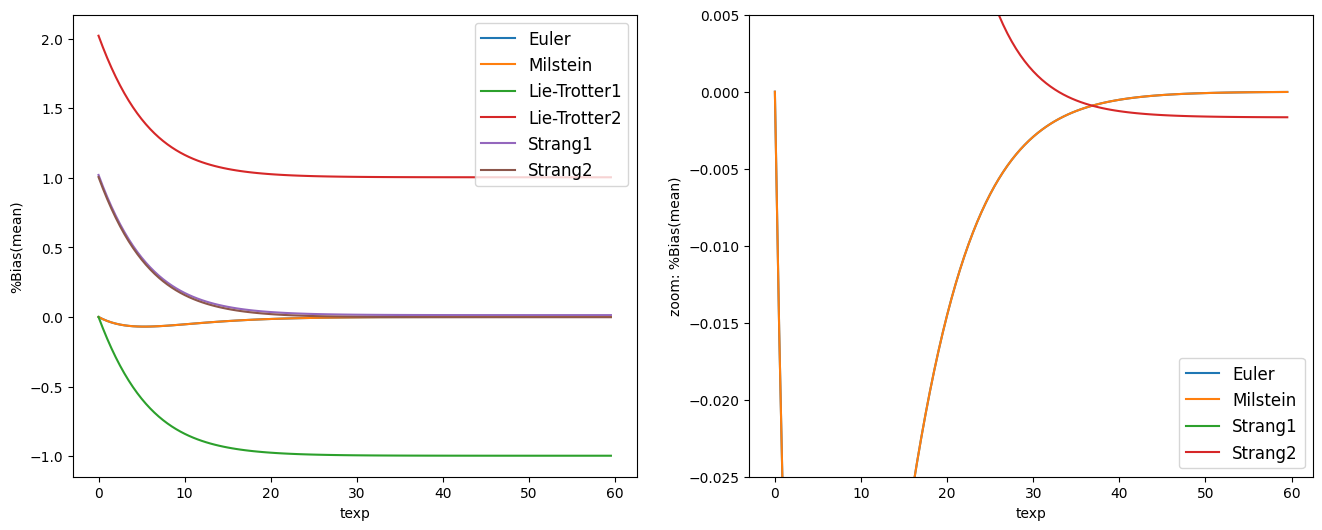

In [15]:
sigma_0 = 6
dt = 0.1
mr = 0.2
theta = 5
vov = 0.2
texp_arr = np.arange(0, 60, 0.5)

mean_theo = np.zeros(len(texp_arr))
var_theo = np.zeros(len(texp_arr))
mean_error = np.zeros((len(scheme_dict),len(texp_arr)))
var_error = np.zeros((len(scheme_dict),len(texp_arr)))

igbm_theo = IGBM_theoretical(mr, theta, vov)
for i,texp in enumerate(texp_arr):
    mean_theo[i] = igbm_theo.cond_mean(sigma_0,texp)
    var_theo[i] = igbm_theo.cond_var(sigma_0,texp)

igbm_numer = IGBM_numerical(mr, theta, vov)
for scheme in scheme_dict:
    for i,texp in enumerate(texp_arr):
        var_t = igbm_numer.cond_mean(sigma_0, texp, dt, scheme)
        mean_error[scheme][i] = (var_t - mean_theo[i]) / mean_theo[i] * 100

# Create a new figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot the mean error for all schemes in the first subplot
for scheme in scheme_dict:
    ax[0].plot(texp_arr, mean_error[scheme], label=scheme_dict[scheme])
ax[0].set_xlabel('texp')
ax[0].set_ylabel('%Bias(mean)')
ax[0].legend(loc=0, fontsize='large')

# Plot the mean error for selected schemes in the second subplot
for scheme in [0,1,4,5]:
    ax[1].plot(texp_arr, mean_error[scheme], label=scheme_dict[scheme])
ax[1].set_ylim([-0.025,0.005])
ax[1].set_xlabel('texp')
ax[1].set_ylabel('zoom: %Bias(mean)')
ax[1].legend(loc=0, fontsize='large')

plt.show()

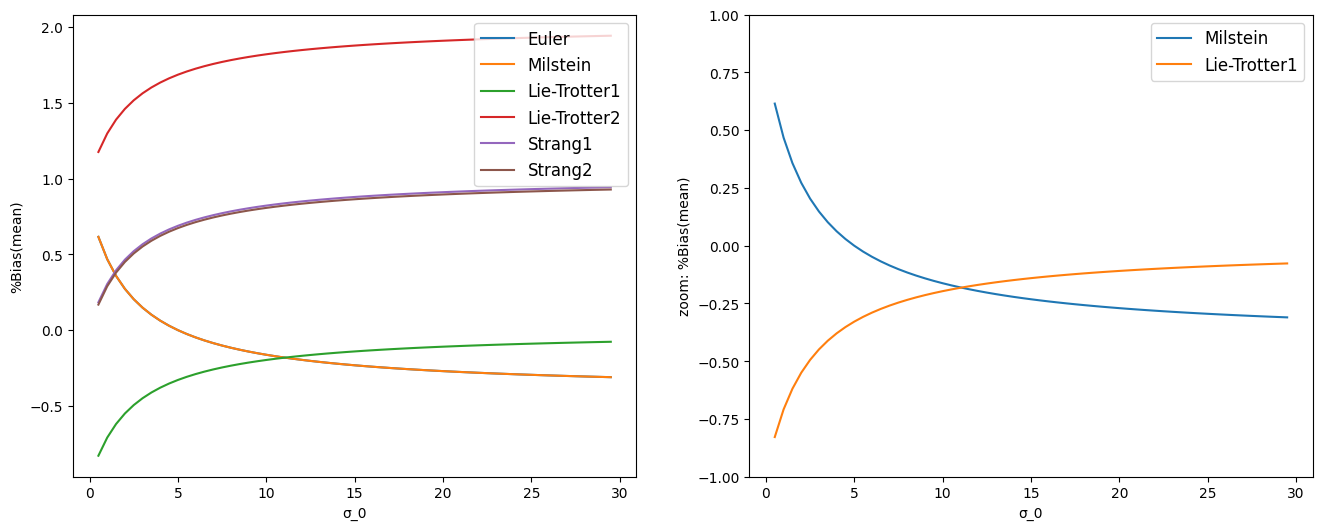

In [16]:
import matplotlib.pyplot as plt

sigma_arr = np.arange(0.5,30,0.5)
dt = 0.1
mr = 0.2
theta = 5
vov = 0.2
texp = 2

mean_theo = np.zeros(len(sigma_arr))
var_theo = np.zeros(len(sigma_arr))
mean_error = np.zeros((len(scheme_dict),len(sigma_arr)))
var_error = np.zeros((len(scheme_dict),len(sigma_arr)))

igbm_theo = IGBM_theoretical(mr, theta, vov)
for i,sigma_0 in enumerate(sigma_arr):
    mean_theo[i] = igbm_theo.cond_mean(sigma_0,texp)
    var_theo[i] = igbm_theo.cond_var(sigma_0,texp)

igbm_numer = IGBM_numerical(mr, theta, vov)
for scheme in scheme_dict:
    for i,sigma_0 in enumerate(sigma_arr):
        var_t = igbm_numer.cond_mean(sigma_0, texp, dt, scheme)
        mean_error[scheme][i] = (var_t - mean_theo[i]) / mean_theo[i] * 100

# Create a new figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot the mean error for all schemes in the first subplot
for scheme in scheme_dict:
    ax[0].plot(sigma_arr, mean_error[scheme], label=scheme_dict[scheme])
ax[0].set_xlabel('σ_0')
ax[0].set_ylabel('%Bias(mean)')
ax[0].legend(loc=0, fontsize='large')

# Plot the mean error for selected schemes in the second subplot
for scheme in [1,2]:
    ax[1].plot(sigma_arr, mean_error[scheme], label=scheme_dict[scheme])
ax[1].set_ylim([-1,1])
ax[1].set_xlabel('σ_0')
ax[1].set_ylabel('zoom: %Bias(mean)')
ax[1].legend(loc=0, fontsize='large')

plt.show()

# Part II: Approximation of implied volatilities for the inhomogeneous geometric Brownian motion


## 1. Black-Scholes implied volatility

The basic GARCH Diffusion process, say IGBM, is following:

$$
\begin{align*}
    &dS_t = \mu dt + \sqrt{Y_t}dW_t \\
    &dY_t = a(b-Y_t)dt + \sigma Y_tdB_t  \\
    &\qquad where\ dW_tdB_t = \rho dt &
\end{align*}
$$

The Black-Scholes implied volatility (or simply the implied volatility) $IV_t(K, T)$ of, let's say, a European call option with maturity date $T > t$ and strike price$ K > 0 $is defined as the value of the volatility parameter in the Black-Scholes formula such that the Black-Scholes price coincides with the actual option price $C_t(K, T)$:
$$
 C_t(K, T) = C^{BS}(X_t, K, \tau, IV_t)  \tag{2}
$$
where
$$
 d_1 = \frac{X_t}{IV_t \sqrt{\tau}}+\frac{1}{2} IV_t \sqrt{\tau}
$$
$$
 d_2 = = \frac{X_t}{IV_t \sqrt{\tau}}-\frac{1}{2} IV_t \sqrt{\tau}
$$
$$
 N(d) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{d} e^{-\frac{s^2}{2}} ds 
$$
and $ \tau = T - t $ is the option time-to-maturity, $ X_t = \log \left( \frac{S_t e^{(r - \delta)\tau}}{K} \right) $ is the option moneyness.

To further characterize the implied volatility, recall that the price of a European contingent claim is equal to the risk-neutral expectation of its final payoff discounted at the risk-free rate r. In the case of the call option we have:
$$
C_t(K, T) = e^{-r(T-t)} E_t [S_T - K]_+  \tag{3}
$$

Using the definition of the implied volatility and moneyness we can rewrite (3) as:
$$
e^x_t N (d_1(X_t, IV_t, \tau)) - N (d_2(X_t, IV_t, \tau)) = E_t [e^{X_T }- 1]_+ \tag{4}
$$
Under Model (1) the joint dynamics of $X_t $ and $ \sigma_t $ is a time-homogeneous Markov process. Hence, the expectation on the right hand side of (4) is a deterministic function of $X_t$, $ \tau$, and $ \sigma_t $. As a consequence, the implied volatility can be characterized by:
$$
IV_t(K,T) = I(X_t, \tau; \sigma_t),\tag{5}
$$
where $I $ is a deterministic function. It is important to note that the function $I(X,\tau; \sigma) $ does not depend on the risk-free rate and the dividend yield. Hence we can safely assume $ r = \delta = 0 $ when working with implied volatilities instead of option prices. This point is easily deduced from (4) taking into account that the dynamics of $ X_t $ does not depend neither on $ r $ nor on $ \delta $. In applications we should however take into account both the interest rate and the dividend yield to convert strike price $ K $ into moneyness $ X $.
The function $ I(X, \tau; \sigma)$ is generally not available in closed-form except for few special cases. In the case of the stochastic volatility model (1) without jumps it is known that the at-the-money implied volatility converges to the spot volatility as time-to-maturity shrinks to zero (see e.g. Ledoit et al. (2002)):
$$
\lim_{\tau \to 0} I(0, \tau; \sigma) = I(0, 0; \sigma) = \sigma
$$
Taking into account that the implied volatility is known in the limit it is reasonable to consider its Taylor series expansion of $ I(X, T; \sigma) $ around $ X = T = 0 $:
$$
I(X, \tau; \sigma) = \sigma + \frac{\partial I(0, 0; \sigma)}{\partial X} X + \frac{\partial I(0, 0; \sigma)}{\partial \tau} \tau + \ldots \tag{6}
$$

This power series is defined only if the function $ I $ is well-behaved for small $ X $ and $ \tau $, which is not the case if jumps are present (see more about this in the next section). This difficulty can be overcome by introducing an alternative parameterization of implied volatility. Indeed, let


# 2. Asymptotic expansion of implied volatility
In this section we present the main theoretical result of the paper, namely the asymptotic expansion of implied volatility. We begin with a pure diffusion stochastic volatility model without jumps before turning our attention towards jump-diffusion models.

## Garch diffusion case
The next proposition contains our expansion result for implied volatilities in the pure diffusion case.

**Proposition 1**: In Model (1) without jumps assume that for any level of σ the implied volatility function admits a Taylor series representation in some neighborhood of$ X = τ = 0$:
$$
I(X, τ; σ) = \sum_{n,m=0}^{\infty} \frac{\partial^{(n+m)}}{\partial X^n \partial τ^m} I(0, 0; σ) X^n τ^m \tag{8}
$$
then the implied volatility function I has the following asymptotics:
$$
I(θ, τ; σ) = σ + I_1(θ; σ) \sqrt{τ} + I_2(θ; σ) τ + O(τ\sqrt{τ})\tag{9}
$$
where$ I1 $and$ I2$ are functions of the moneyness degree$ θ $and the spot volatility $ σ  $only:
$$
I_1(θ; σ) = -\rho b \frac{θ}{2}\tag{10}
$$
$$
I_2(θ; σ) = \mu - \frac{5}{12}ρ^2b^2σ + \frac{1}{6}b^2σ + \frac{1}{6}ρ^2bb'θ^2 + a + \frac{ρbσ}{4} + \frac{1}{24}ρ^2b^2σ - \frac{1}{12}b^2σ\tag{11}
$$
with $a = a(σ), b = b(σ),$ and b' denotes the derivative of b w.r.t. σ.




$$dv_t = \kappa(\theta - v_t)dt + \nu v_t dZ_t$$  
$$v_t = \sigma_t^2$$
the SDE for $\sigma_t$ is

$$d\sigma_t  = d\sqrt{v_t} = \frac{1}{2\sqrt{v_t}}dv_t - \frac{1}{8v_t\sqrt{v_t}}(dv_t)^2 $$

$$ = -\frac{\kappa}{2} \left(\frac{\theta}{\sigma_t} - \sigma_t\right) dt + \frac{\nu}{2} \sigma_t dZ_t - \frac{\nu^2}{8} \sigma_t dt $$

$$= \frac{1}{2} \left( \frac{\kappa\theta}{\sigma_t} - \left(\kappa + \frac{\nu^2}{4}\right) \sigma_t \right) dt + \frac{\nu}{2} \sigma_t dZ_t.$$

where $dZ_t = \rho dB_t + \sqrt{1-\rho^2}dW_t$
such that, 

$$ a(\sigma_t) = \frac{1}{2} \left( \frac{\kappa\theta}{\sigma_t} - \left(\kappa + \frac{\nu^2}{4}\right) \sigma_t \right)$$

$$ b(\sigma_t) = \frac{\nu}{2} \sigma_t$$

$$ b'(\sigma_t) = \frac{\nu}{2} $$ 

$$I_1(\theta; \sigma) = -\frac{\rho b \theta}{2},$$

$$I_2(\theta; \sigma) = \left( -\frac{5 \rho^2 b^2}{12 \sigma} + \frac{1}{6} \frac{b^2}{\sigma} + \frac{1}{6} \rho^2 bb' \right) \theta^2$$ 

$$+ \frac{a}{2} + \frac{\rho b \sigma}{4} + \frac{1}{24} \frac{\rho^2 b^2}{\sigma} + \frac{1}{12} b^2 - \frac{1}{6} \rho^2 bb',$$

we will compare the exat sigma and approximate sigma around $X = \tau = 0$

In [17]:
import numpy as np
import scipy.stats as spst
from pyfeng import sv_abc as sv
from pyfeng import bsm

In [18]:
class GarchIV2007(sv.SvABC):

    model_type = "GarchDiff"
    var_process = True

    def __init__(self, sigma, vov=0.01, rho=0.0, mr=0.01, theta=None, intr=0.0, divr=0.0, is_fwd=False):
        super().__init__(sigma, vov, rho, mr, theta, intr, divr, is_fwd)

    def IV(self, texp, var0):
        """
        Args:
            var0: initial variance
        Returns:
            mean, variance
        """
        mr, vov, theta = self.mr, self.vov, self.theta
        a = 0.5 * (mr * theta /var0 - (mr + 0.25 * vov * vov) * var0)
        b = vov * 0.5 * var0
        b1 = 0.5 * vov

        I1 = -0.5 * self.rho * b * theta
        c1 = -5/12 * self.rho**2 * b**2/var0 +b**2/(6 * var0) + self.rho**2 * b * b1/6
        c2 = 0.5 * a + 0.25 * self.rho * b *var0 + self.rho**2 * b**2/(24 * var0) +b**2/12 - self.rho**2 * b * b1/6
        I2 = c1 * theta**2 + c2
        vart = var0 + I1 * np.sqrt(texp)+ I2 * texp
        
        return vart
    
    def price(self, strike, spot, texp, cp=1):
        var0 = self.sigma**2
        vart = self.IV(texp, var0)

        m_bs = bsm.Bsm(np.sqrt(vart), intr=self.intr, divr=self.divr)
        price = m_bs.price(strike, spot, texp, cp)

        return price

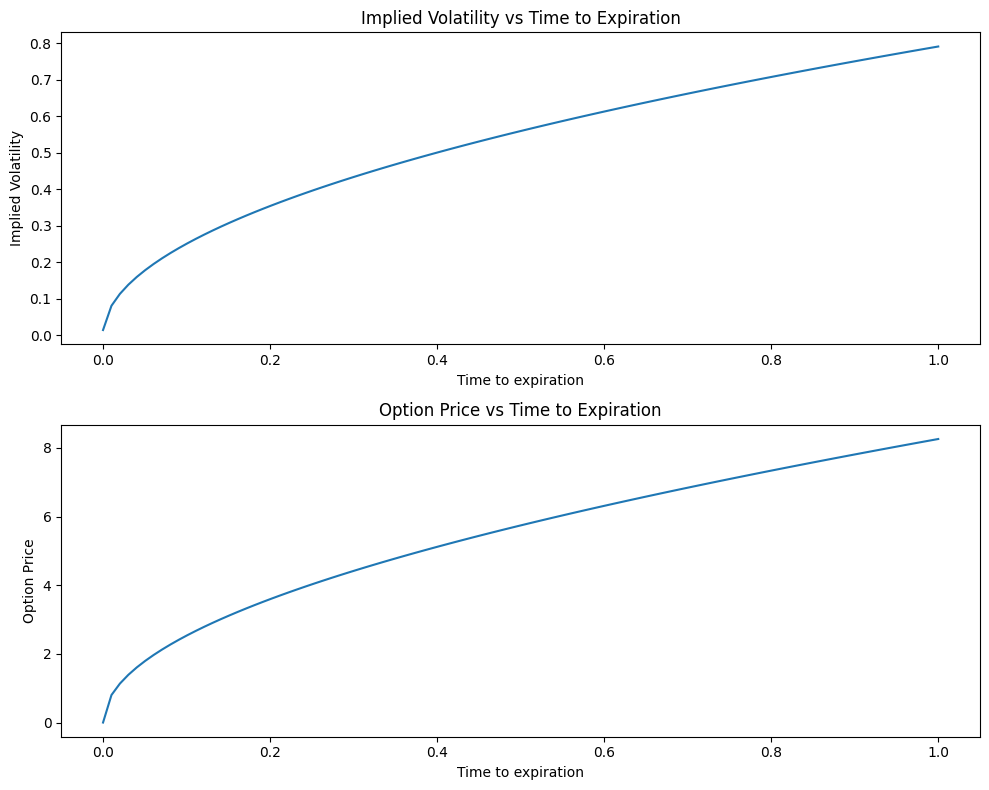

In [19]:

garch = GarchIV2007(sigma=0.2, rho=0.5, vov=0.05, theta=0.05)


var0 = 0.0002
spot = 100


texp = np.linspace(0, 1, 100)

vart = np.array([garch.IV(t, var0) for t in texp])
ivol = np.sqrt(vart)  
prices = np.array([garch.price(spot, spot, t) for t in texp])

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(texp, ivol)
ax[0].set_xlabel('Time to expiration')
ax[0].set_ylabel('Implied Volatility')
ax[0].set_title('Implied Volatility vs Time to Expiration')

ax[1].plot(texp, prices)
ax[1].set_xlabel('Time to expiration')
ax[1].set_ylabel('Option Price')
ax[1].set_title('Option Price vs Time to Expiration')

# 显示图像
plt.tight_layout()
plt.show()

allow us to compute the expansion of the call option price. After some simple but tedious algebra we finally obtain:
$$
C K^{-1} = e^{-r\tau}(e^{X_t} N(d_1) - N(d_2)) = A_1 \sqrt{\tau} + A_2 \tau + A_3 \tau \sqrt{\tau} + O(\tau^2)\tag{11}
$$
where
$$
A_1 = σ(n + \theta N),\tag{12}
$$
$$
A_2 = \frac{1}{2}\theta^2 N^2σ^2 + \frac{1}{2}\theta nσ^2 + n I_1,\tag{13}
$$
$$
A_3 = \theta^3 N \frac{σ^3}{6} + \theta^2 n \frac{σ^3}{6} - n \frac{1}{24} σ^3 + \frac{n \theta^2 I_1^2}{2σ} + \frac{\sigma  \theta n I_1 }{2}+ n I_2 - \sigma r (n + \theta N),\tag{14}
$$
and $ n = n(\theta), N = N(\theta) $ are the pdf and cdf of the standard normal distribution evaluated at $ \theta$.


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 定义CK函数
def CK(texp, garch):
    theta, sigma, r, mr, vov, var0, rho = garch.theta, garch.sigma, garch.intr, garch.mr, garch.vov, garch.sigma**2, garch.rho
    n = norm.pdf(theta)
    N = norm.cdf(theta)
    
    a = 0.5 * (mr * theta / var0 - (mr + 0.25 * vov**2) * var0)
    b = vov * 0.5 * var0
    b1 = 0.5 * vov
    
    I1 = -0.5 * rho * b * theta
    c1 = -5/12 * rho**2 * b**2 / var0 + b**2 / (6 * var0) + rho**2 * b * b1 / 6
    c2 = 0.5 * a + 0.25 * rho * b * var0 + rho**2 * b**2 / (24 * var0) + b**2 / 12 - rho**2 * b * b1 / 6
    I2 = c1 * theta**2 + c2
    
    A1 = sigma * (n + theta * N)
    A2 = (1/2) * theta**2 * N**2 * sigma**2 + (1/2) * theta * n * sigma**2 + n * I1
    A3 = theta**3 * N * sigma**3 / 6 + theta**2 * n * sigma**3 / 6 - n * sigma**3 / 24 + (n * theta**2 * I1**2) / (2 * sigma) + (sigma * n * theta * I1) / 2 + n * I2 - sigma * r * (n + theta * N)
    
    CK_value = A1 * np.sqrt(texp) + A2 * texp + A3 * texp * np.sqrt(texp)
    
    return CK_value

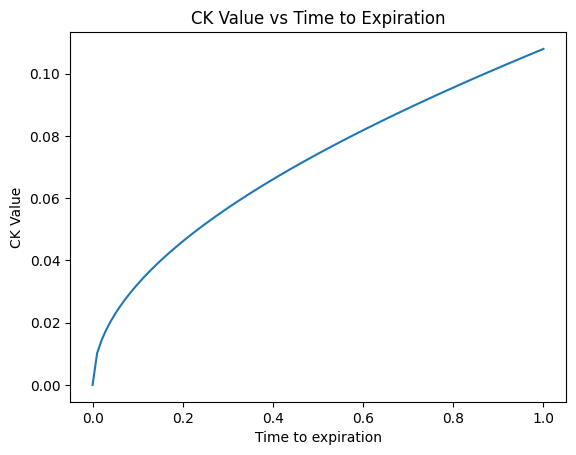

In [21]:
garch = GarchIV2007(sigma=0.2, rho=0.0)

# 创建一个时间序列
texp = np.linspace(0, 1, 100)

# 计算每个时间点的CK值
CK_values = np.array([CK(t, garch) for t in texp])

# 绘制CK值随时间变化的图像
plt.plot(texp, CK_values)
plt.xlabel('Time to expiration')
plt.ylabel('CK Value')
plt.title('CK Value vs Time to Expiration')
plt.show()

## Calibration of the implied volatility smile

In [25]:
import pandas as pd
import os
import chardet

data_folder = "C:/rrhw/data"
df_final = pd.DataFrame()

for subdir, dirs, files in os.walk(data_folder):
    for folder in dirs:
        folder_path = os.path.join(data_folder, folder)
        for file in os.listdir(folder_path):
            if file.endswith('.csv'):
                file_path = os.path.join(folder_path, file)
                with open(file_path, 'rb') as f:
                    result = chardet.detect(f.read())
                    encoding = result['encoding']
                df = pd.read_csv(file_path, encoding=encoding)
                
                # 提取日期并添加为新的列
                date = file.split('_')[0]
                df['date'] = pd.to_datetime(date, format='%Y%m%d')
                
                df_final = pd.concat([df_final, df], ignore_index=True)

df = df_final[df_final['合约代码'].str.slice(start=0, stop=13) == 'IO2312-C-4000'].dropna()
df

,合约代码,今开盘,最高价,最低价,成交量,成交金额,持仓量,持仓变化,今收盘,今结算,前结算,涨跌1,涨跌2,Delta,date
419,IO2312-C-4000,232.8,250.8,232.8,6,14.570,52.0,0.0,250.8,253.4,242.2,8.6,11.2,0.4780,2023-01-03
1079,IO2312-C-4000,248.8,249.8,242.6,20,49.066,61.0,9.0,242.6,243.4,253.4,-10.8,-10.0,0.4720,2023-01-04
1739,IO2312-C-4000,267.0,267.0,267.0,1,2.670,62.0,1.0,267.0,276.4,243.4,23.6,33.0,0.5090,2023-01-05
2399,IO2312-C-4000,267.0,287.6,267.0,4,11.094,64.0,2.0,287.6,288.4,276.4,11.2,12.0,0.5190,2023-01-06
3059,IO2312-C-4000,306.0,306.0,299.4,2,6.054,64.0,0.0,299.4,308.6,288.4,11.0,20.2,0.5320,2023-01-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153002,IO2312-C-4000,0.4,0.6,0.2,305,1.374,4321.0,-153.0,0.4,0.6,0.4,0.0,0.2,0.0010,2023-12-11
153728,IO2312-C-4000,0.4,0.4,0.2,480,1.224,4048.0,-273.0,0.4,0.4,0.6,-0.2,-0.2,0.0060,2023-12-12
154454,IO2312-C-4000,0.2,0.4,0.2,274,0.616,3855.0,-193.0,0.2,0.2,0.4,-0.2,-0.2,0.0040,2023-12-13
155181,IO2312-C-4000,0.2,0.2,0.2,163,0.326,3755.0,-100.0,0.2,0.2,0.2,0.0,0.0,0.0030,2023-12-14


In [26]:
# 提取到期年月和期权类型
df['texp'] = pd.to_datetime(df['合约代码'].str.extract('IO(\d{4})')[0], format='%y%m')
df['cp'] = df['合约代码'].str.extract('-(C|P)-')[0].map({'C': 1, 'P': -1})

# 重命名列
df = df.rename(columns={'今收盘': 'spot'})

# 计算到期时间（以年为单位）
df['texp'] = (df['texp'] - pd.Timestamp.today()) / pd.Timedelta(days=365)
# 提取行权价格
df['strike'] = df['合约代码'].str[9:13].astype(int)

# 将date列转换为日期格式
df['date'] = pd.to_datetime(df['date'])

# 计算每个合约的总日期数
df['total_days'] = df.groupby('合约代码')['date'].transform(lambda x: (x.max() - x.min()).days)

# 计算texp
# 计算每个合约的最早日期
df['min_date'] = df.groupby('合约代码')['date'].transform('min')

# 计算texp
df['texp'] = (df['date'] - df['min_date']).dt.days / df['total_days']
df

,合约代码,今开盘,最高价,最低价,成交量,成交金额,持仓量,持仓变化,spot,今结算,前结算,涨跌1,涨跌2,Delta,date,texp,cp,strike,total_days,min_date
419,IO2312-C-4000,232.8,250.8,232.8,6,14.570,52.0,0.0,250.8,253.4,242.2,8.6,11.2,0.4780,2023-01-03,0.000000,1,4000,346,2023-01-03
1079,IO2312-C-4000,248.8,249.8,242.6,20,49.066,61.0,9.0,242.6,243.4,253.4,-10.8,-10.0,0.4720,2023-01-04,0.002890,1,4000,346,2023-01-03
1739,IO2312-C-4000,267.0,267.0,267.0,1,2.670,62.0,1.0,267.0,276.4,243.4,23.6,33.0,0.5090,2023-01-05,0.005780,1,4000,346,2023-01-03
2399,IO2312-C-4000,267.0,287.6,267.0,4,11.094,64.0,2.0,287.6,288.4,276.4,11.2,12.0,0.5190,2023-01-06,0.008671,1,4000,346,2023-01-03
3059,IO2312-C-4000,306.0,306.0,299.4,2,6.054,64.0,0.0,299.4,308.6,288.4,11.0,20.2,0.5320,2023-01-09,0.017341,1,4000,346,2023-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153002,IO2312-C-4000,0.4,0.6,0.2,305,1.374,4321.0,-153.0,0.4,0.6,0.4,0.0,0.2,0.0010,2023-12-11,0.988439,1,4000,346,2023-01-03
153728,IO2312-C-4000,0.4,0.4,0.2,480,1.224,4048.0,-273.0,0.4,0.4,0.6,-0.2,-0.2,0.0060,2023-12-12,0.991329,1,4000,346,2023-01-03
154454,IO2312-C-4000,0.2,0.4,0.2,274,0.616,3855.0,-193.0,0.2,0.2,0.4,-0.2,-0.2,0.0040,2023-12-13,0.994220,1,4000,346,2023-01-03
155181,IO2312-C-4000,0.2,0.2,0.2,163,0.326,3755.0,-100.0,0.2,0.2,0.2,0.0,0.0,0.0030,2023-12-14,0.997110,1,4000,346,2023-01-03


In [27]:
# 创建GarchIV2007对象
garch = GarchIV2007(sigma=0.2, vov=0.01, rho=0.0, mr=0.01, theta=0.01, intr=0.0, divr=0.0, is_fwd=False)
df['implied_volatility'] = df.apply(lambda row: garch.IV(row['texp'], 0.2**2), axis=1)
df

,合约代码,今开盘,最高价,最低价,成交量,成交金额,持仓量,持仓变化,spot,今结算,...,涨跌1,涨跌2,Delta,date,texp,cp,strike,total_days,min_date,implied_volatility
419,IO2312-C-4000,232.8,250.8,232.8,6,14.570,52.0,0.0,250.8,253.4,...,8.6,11.2,0.4780,2023-01-03,0.000000,1,4000,346,2023-01-03,0.040000
1079,IO2312-C-4000,248.8,249.8,242.6,20,49.066,61.0,9.0,242.6,243.4,...,-10.8,-10.0,0.4720,2023-01-04,0.002890,1,4000,346,2023-01-03,0.040002
1739,IO2312-C-4000,267.0,267.0,267.0,1,2.670,62.0,1.0,267.0,276.4,...,23.6,33.0,0.5090,2023-01-05,0.005780,1,4000,346,2023-01-03,0.040003
2399,IO2312-C-4000,267.0,287.6,267.0,4,11.094,64.0,2.0,287.6,288.4,...,11.2,12.0,0.5190,2023-01-06,0.008671,1,4000,346,2023-01-03,0.040005
3059,IO2312-C-4000,306.0,306.0,299.4,2,6.054,64.0,0.0,299.4,308.6,...,11.0,20.2,0.5320,2023-01-09,0.017341,1,4000,346,2023-01-03,0.040009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153002,IO2312-C-4000,0.4,0.6,0.2,305,1.374,4321.0,-153.0,0.4,0.6,...,0.0,0.2,0.0010,2023-12-11,0.988439,1,4000,346,2023-01-03,0.040519
153728,IO2312-C-4000,0.4,0.4,0.2,480,1.224,4048.0,-273.0,0.4,0.4,...,-0.2,-0.2,0.0060,2023-12-12,0.991329,1,4000,346,2023-01-03,0.040520
154454,IO2312-C-4000,0.2,0.4,0.2,274,0.616,3855.0,-193.0,0.2,0.2,...,-0.2,-0.2,0.0040,2023-12-13,0.994220,1,4000,346,2023-01-03,0.040522
155181,IO2312-C-4000,0.2,0.2,0.2,163,0.326,3755.0,-100.0,0.2,0.2,...,0.0,0.0,0.0030,2023-12-14,0.997110,1,4000,346,2023-01-03,0.040523


In [28]:
market_data=df[['strike','spot','texp','cp','implied_volatility']].dropna()
market_data

,strike,spot,texp,cp,implied_volatility
419,4000,250.8,0.000000,1,0.040000
1079,4000,242.6,0.002890,1,0.040002
1739,4000,267.0,0.005780,1,0.040003
2399,4000,287.6,0.008671,1,0.040005
3059,4000,299.4,0.017341,1,0.040009
...,...,...,...,...,...
153002,4000,0.4,0.988439,1,0.040519
153728,4000,0.4,0.991329,1,0.040520
154454,4000,0.2,0.994220,1,0.040522
155181,4000,0.2,0.997110,1,0.040523


In [29]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

market_data=df[['strike','spot','texp','cp','implied_volatility']]

# 定义损失函数
def loss_function(params):
    sigma, vov, rho, mr, theta, intr, divr = params
    model = GarchIV2007(sigma, vov, rho, mr, theta, intr, divr)
    model_prices = model.price(
        strike=market_data['strike'],
        spot=market_data['spot'],
        texp=market_data['texp'],
        cp=market_data['cp']
    )
    return np.sum((model_prices - market_data['implied_volatility']) ** 2)


initial_guess = [0.2, 0.1, -0.5, 0.01, 0.2, 0.05, 0.03]


result = minimize(
    fun=loss_function,
    x0=initial_guess,
    method='Nelder-Mead'  
)
print("Optimized parameters:", result.x)

# 使用最佳参数更新模型
optimized_params = result.x
optimized_model = GarchIV2007(
    sigma=optimized_params[0],
    vov=optimized_params[1],
    rho=optimized_params[2],
    mr=optimized_params[3],
    theta=optimized_params[4],
    intr=optimized_params[5],
    divr=optimized_params[6]
)

# 计算校准后的隐含波动率
calibrated_implied_vols = []
for texp in market_data['texp']:
    var0 = optimized_model.sigma**2
    vart = optimized_model.IV(texp, var0)
    calibrated_implied_vols.append(vart)

print("Calibrated implied volatilities:", calibrated_implied_vols)

Optimized parameters: [ 0.2   0.1  -0.5   0.01  0.2   0.05  0.03]
Calibrated implied volatilities: [0.04000000000000001, 0.04004110616336352, 0.04007906311932831, 0.04011650195300208, 0.04022754931878601, 0.04026433455757153, 0.04030104675888783, 0.04033769927043735, 0.04037430181060099, 0.040483875254493776, 0.04052033709553909, 0.04055677323832871, 0.04059318621414768, 0.04062957816414892, 0.040992648200046694, 0.04102889093595229, 0.04106512459703617, 0.04110134964884845, 0.04124617181355598, 0.04128235959397628, 0.04131854088191516, 0.04135471594609231, 0.041499358741530955, 0.04153550614026803, 0.041571648600392315, 0.041607786293214315, 0.041643919380363735, 0.04175229249408923, 0.04178840860597231, 0.041824520798953664, 0.041860629190030134, 0.04189673389049043, 0.042005026883247545, 0.04204111783269667, 0.04207720557467138, 0.042113290193218425, 0.04214937176877692, 0.04229366913514231, 0.04232973659014507, 0.042365801419931265, 0.042401863684855184, 0.042510035660533456, 0.042